In [4]:
import os 
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2

from ren_utils.rennet import call_by_inspect 
import matplotlib.pyplot as plt

import sjldpm as pkg

In [2]:
def data_generator(dataset,*, batch_size, T, bar_alpha, bar_beta):
    """
    `dataset`, allow:
    * dataset[i] -> ndarray () 
    * len(dataset)-> int
    """
    assert hasattr(dataset,"__getitem__")
    assert hasattr(dataset,"__len__")
    batch_imgs = []
    while True:
        for i in np.random.permutation(len(dataset)):
            batch_imgs.append(dataset[i])
            if len(batch_imgs) == batch_size:
                batch_imgs = np.array(batch_imgs)
                batch_steps = np.random.choice(T, batch_size)
                batch_bar_alpha = bar_alpha[batch_steps][:, None, None, None]
                batch_bar_beta = bar_beta[batch_steps][:, None, None, None]
                batch_noise = np.random.randn(*batch_imgs.shape)
                batch_noisy_imgs = batch_imgs * batch_bar_alpha + batch_noise * batch_bar_beta
                yield [batch_noisy_imgs, batch_steps[:, None]], batch_noise
                batch_imgs = []

In [3]:
from sjldpm.apps.reference.ddpm2_h import imread,list_pictures
from ren_utils import rennet
class CelebAHQ:
    def __init__(self,image_resize):
        """
        image_resize: tuple(int,int)
        """
        img_path_list = []
        for _name in ["CelebAHQ256","CelebAHQ256_valid"]:
            img_path_list += list_pictures(rennet.datasets[_name]["imgs"],rennet.datasets[_name]["suffix"] )
        np.random.shuffle(img_path_list)
        self.img_path_list = img_path_list
        
        self.image_resize = image_resize
    def __getitem__(self,i):
        return imread( self.img_path_list[i], self.image_resize)
    
    def __len__(self):
        return len(self.img_path_list)

In [15]:
celeb = CelebAHQ((64,64))
img = celeb[0]
print(img.shape, type(img),img.max(),img.min())

(64, 64, 3) <class 'numpy.ndarray'> 0.827451 -0.99215686


In [41]:
import sjldpm
import cv2
class MNIST:
    root_pkg = Path(sjldpm.__file__).parent
    npz_path = Path(root_pkg,"../Datasets/MNIST/mnist.npz").as_posix()
    def __init__(self,image_resize,digits=[0,1,2,3,4,5,6,7,8,9]):
    
        data_npz  = np.load(self.npz_path)
        x_train = data_npz["x_train"]
        y_train = data_npz["y_train"]
        
        index = []
        for i in range(len(y_train)):
            if y_train[i] in digits:
                index.append(i)
        
        np.random.shuffle(index)
        
        x= (x_train/255)*2-1
        x_= np.zeros((*image_resize,3,len(index)))
        y_ = np.zeros(len(index))
        for i in range(len(index)):
            x_[:,:,0,i]= cv2.resize(x[index[i]],image_resize)
            x_[:,:,1,i]= cv2.resize(x[index[i]],image_resize)
            x_[:,:,2,i]= cv2.resize(x[index[i]],image_resize)
            y_[i] = index[i]
        self.x_ = x_
        self.y_ = y_
        self.index = index
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self,i):
        v = self.x_[:,:,:,i]
        return v

mnist = MNIST((32,32),digits=[0,2,4,6])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23641
(32, 32, 3, 23641) 1.0 -1.0
(32, 32, 3) -1.0 1.0


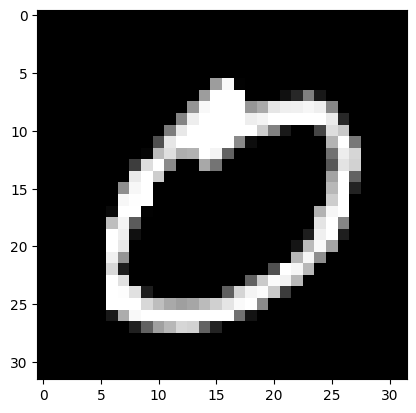

In [42]:
print(len(mnist.index))
print(mnist.x_.shape, mnist.x_.max(),mnist.x_.min())
img = mnist[0]
print(img.shape,img.min(),img.max())
plt.imshow(img)
plt.show()

In [45]:
T = 10
a = np.arange(1,T+1)/T
print(a)
2 ** a

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


array([1.07177346, 1.14869835, 1.23114441, 1.31950791, 1.41421356,
       1.51571657, 1.62450479, 1.74110113, 1.86606598, 2.        ])